# Implementation AOS6  

*A stochastic block model approach for the analysis of multilevel networks: An application to the sociology of organizations (2021)*
Saint-Clair Chabert-Liddell, Pierre Barbillon, Sophie Donnet, Emmanuel Lazega

This notebook aims at implementing the multilevel stochastic block model, as defined in the article written by Saint-Clair Chabert-Liddell, Pierre Barbillon, Sophie Donnet and Emmanuel Lazega. We will first simulate a multilevel network, then estimate an initial clustering on each level (the inter-organization level and the inter-individual level) to feed the algorithm.

The code is based on both the article and the source code proposed also by the same authors and which available here: https://chabert-liddell.github.io/MLVSBM/

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from random import sample
from scipy.stats import entropy

In [100]:
def classe(node, Z):
    """
    Return the class of the node in the set Z
    
    :param node: node for which we want to obtain the class
    :param Z: List of nodes
    :return: The class of the node
    """
    return sum([i if Z[node][i]==1 else 0 for i in range(len(Z[node]))])

def sum1(QO, nO, toO, pi):
    """
    Return the first sum of the likelihood as given in the variational bound
    
    :param QO: The number of clusters in the organization level
    :param nO: The number of organizations
    :param toO: The clustering
    :param pi: The proportion of each cluster
    """
    somme = 0
    for j in range(nO):
        for l in range(QO):
            somme += toO[j,l]*np.log(pi[l])
    return somme

def sum2(QI, nI, QO, nO, A, toI, toO, gamma):
    """
    Return the second sum of the likelihood as given in the variational bound
    
    :param QI: The number of clusters in the individual level
    :param nI: The number of individuals
    :param QO: The number of clusters in the organization level
    :param nO: The number of organizations
    :param A: The affiliation matrix
    :param toI: The clustering for the individuals
    :param toO: The clustering for the organizations
    :param gamma: The proportion of each cluster from the individual level
    """
    somme_tot = 0
    for i in range(nI):
        for k in range(QI):
            somme_int = 0
            for j in range(nO):
                for l in range(QO):
                    somme_int += A[i,j] * toO[j,l] * np.log(gamma[k,l])
            somme_tot += toI[i,k]*somme_int
    return somme_tot
            
phi = lambda x, a: a**x * (1-a)**(1-x)          
def sum3(QI, nI, toI, XI, alphaI):
    """
    Return the third sum of the likelihood as given in the variational bound
    
    :param QI: The number of clusters in the individual level
    :param nI: The number of individuals
    :param toI: The clustering for the individuals
    :param XI: The adjcacency matrix describing the individual network
    :param alphaI: The probability that a link exists between two individuals given their cluster
    """
    somme_tot = 0
    for i in range(nI):
        for i_prime in range(nI):
            somme_int = 0
            if i!=i_prime:
                for k in range(QI):
                    for k_prime in range(QI):
                        somme_int += toI[i,k]*toI[i_prime,k_prime]*np.log(phi(XI[i,i_prime],alphaI[k,k_prime]))
            somme_tot += somme_int

    return somme_tot

def sum4(QO, nO, toO, XO, alphaO):
    """
    Return the fourth sum of the likelihood as given in the variational bound
    
    :param QO: The number of clusters in the organizational level
    :param nO: The number of organizations
    :param toO: The clustering for the organizations
    :param XO: The adjcacency matrix describing the organizational network
    :param alphaO: The probability that a link exists between two organizations given their cluster
    """
    somme_tot = 0
    for j in range(nO):
        for j_prime in range(nO):
            somme_int = 0
            if j!=j_prime:
                for l in range(QO):
                    for l_prime in range(QO):
                        somme_int += toO[j,l]*toO[j_prime,l_prime]*np.log(phi(XO[j,j_prime],alphaO[l,l_prime]))
            somme_tot += somme_int
    return somme_tot

def likelihood(QO, QI, nO, nI, pi, toI, toO, A, gamma, XI, alphaI, XO, alphaO):
    """
    Return the part of the variational bound which corresponds to the likelihood
    
    :param QI: The number of clusters in the individual level
    :param nI: The number of individuals
    :param QO: The number of clusters in the organization level
    :param nO: The number of organizations
    :param A: The affiliation matrix
    :param toI: The clustering for the individuals
    :param toO: The clustering for the organizations
    :param gamma: The proportion of each cluster from the individual level
    :param XI: The adjcacency matrix describing the individual network
    :param alphaI: The probability that a link exists between two individuals given their cluster
    :param XO: The adjcacency matrix describing the organizational network
    :param alphaO: The probability that a link exists between two organizations given their cluster
    """
    return sum1(QO, nO, toO, pi)+sum2(QI, nI, QO, nO, A, toI, toO, gamma)+1/2*sum3(QI, nI, toI, XI, alphaI)+1/2*sum4(QO, nO, toO, XO, alphaO)

def KL(nI, QI, nO, QO, toI, toO):
     """
    Return the part of the variational bound which corresponds to the Kullback-Leibler divergence
    
    :param QI: The number of clusters in the individual level
    :param nI: The number of individuals
    :param QO: The number of clusters in the organization level
    :param nO: The number of organizations
    :param toI: The clustering for the individuals
    :param toO: The clustering for the organizations
    """
    somme = 0
    for i in range(nI):
        somme+=entropy(toI[i])
    for j in range(nO):
        somme+=entropy(toO[j])
    return somme

def variational_bound(QO, QI, nO, nI, pi, toI, toO, A, gamma, XI, alphaI, XO, alphaO):
    """
    Return the variational bound
    
    :param QI: The number of clusters in the individual level
    :param nI: The number of individuals
    :param QO: The number of clusters in the organization level
    :param nO: The number of organizations
    :param A: The affiliation matrix
    :param toI: The clustering for the individuals
    :param toO: The clustering for the organizations
    :param gamma: The proportion of each cluster from the individual level
    :param XI: The adjcacency matrix describing the individual network
    :param alphaI: The probability that a link exists between two individuals given their cluster
    :param XO: The adjcacency matrix describing the organizational network
    :param alphaO: The probability that a link exists between two organizations given their cluster
    """
    return likelihood(QO, QI, nO, nI, pi, toI, toO, A, gamma, XI, alphaI, XO, alphaO) - KL(nI, QI, nO, QO, toI, toO)

In [ ]:
def M_step(QO,QI,nO,nI,toI,toO,A,XO,XI):
    """
    Compute the M-step of the VEM algorithm
    
    :param QI: The number of clusters in the individual level
    :param nI: The number of individuals
    :param QO: The number of clusters in the organization level
    :param nO: The number of organizations
    :param A: The affiliation matrix
    :param toI: The clustering for the individuals
    :param toO: The clustering for the organizations
    :param XI: The adjcacency matrix describing the individual network
    :param XO: The adjcacency matrix describing the organizational network
    """
    pi = np.zeros(QO)
    gamma = np.zeros((QI,QO))
    alphaI = np.zeros((QI,QI))
    alphaO = np.zeros((QO,QO))
    #Compute new pi
    for l in range(QO):
        for j in range(nO):
            pi[l]+=toO[j,l]
        pi[l]=pi[l]/nO
    #Compute new gamma
    for k in range(QI):
        for l in range(QO):
            denom = 0
            num = 0
            for i in range(nI):
                for j in range(nO):
                    num+=toI[i,k]*A[i,j]*toO[j,l]
                    denom+=A[i,j]*toO[j,l]
            gamma[k,l]=num/denom
    #Compute new alphaO
    for l in range(QO):
        for l_prime in range(QO):
            denom=0
            num=0
            for j in range(nO):
                for j_prime in range(nO):
                    if j!=j_prime:
                        num+=toO[j,l]*XO[j,j_prime]*toO[j_prime,l_prime]
                        denom+=toO[j,l]*toO[j_prime,l_prime]
            alphaO[l,l_prime]=num/denom
    #Compute new alphaI
    for k in range(QI):
        for k_prime in range(QI):
            denom=0
            num=0
            for i in range(nI):
                for i_prime in range(nI):
                    if i!=i_prime:
                        num+=toI[i,k]*XI[i,i_prime]*toI[i_prime,k_prime]
                        denom+=toI[i,k]*toI[i_prime,k_prime]
            alphaI[k,k_prime]=num/denom
    return pi, gamma, alphaO, alphaI

def VE_step(QO,QI,nO,nI,toI,toO,pi,alphaI,alphaO,gamma,A,iterations):
    """
    Compute the VE-step of the VEM algorithm.
    
    :param QI: The number of clusters in the individual level
    :param nI: The number of individuals
    :param QO: The number of clusters in the organization level
    :param nO: The number of organizations
    :param A: The affiliation matrix
    :param toI: The clustering for the individuals
    :param toO: The clustering for the organizations
    :param gamma: The proportion of each cluster from the individual level
    :param alphaI: The probability that a link exists between two individuals given their cluster
    :param alphaO: The probability that a link exists between two organizations given their cluster
    :param iterations: The number of times we repeat the process so that we can reach the convergence
    """
    for iter in range(iterations):
        new_toI = np.ones((nI,QI))
        new_toO = np.zeros((nO,QO))

        #Compute the new toO
        for j in range(nO):
            for l in range(QO):
                prod=pi[l]
                for i in range(nI):
                    for k in range(QI):
                        prod_int = 1
                        for j_prime in range(nO):
                            if j!=j_prime:
                                for l_prime in range(QO):
                                    prod_int *= phi(XO[j,j_prime],alphaO[l,l_prime])**toO[j_prime,l_prime]
                        prod *= gamma[k,l]**(A[i,l]*toI[i,k])*prod_int
                new_toO[j,l]=prod
        new_toO[new_toO < 10**-6] = 10**-6
        norm_O = np.sum(new_toO, axis=1)
        new_toO = new_toO.astype(float) / norm_O[:, None]
        toO = new_toO
        
        #Compute the new toI
        for i in range(nI):
            for k in range(QI):
                for j in range(nO):
                    for l in range(QO):
                        prod_int = 1
                        for i_prime in range(nI):
                            if i!=i_prime:
                                for k_prime in range(QI):
                                    prod_int*=phi(XI[i,i_prime],alphaI[k,k_prime])**toI[i_prime,k_prime]
                        prod_int*=gamma[k,l]**(A[i,l]*toO[j,l])
                new_toI[i,k]=prod_int
        new_toI[new_toI < 10**-6] = 10**-6
        norm_I = np.sum(new_toI, axis=1)
        new_toI = new_toI.astype(float) / norm_I[:, None]
        toI = new_toI
    return toO, toI

def VE_step_log(QO,QI,nO,nI,toI,toO,pi,alphaI,alphaO,gamma,A,iterations):
    """
    Compute the VE-step of the VEM algorithm. In particular, this function uses the logarithm to compute the
    new value of toI and toO and then apply an exponential on the coefficient of the resulting matrix.
    
    :param QI: The number of clusters in the individual level
    :param nI: The number of individuals
    :param QO: The number of clusters in the organization level
    :param nO: The number of organizations
    :param A: The affiliation matrix
    :param toI: The clustering for the individuals
    :param toO: The clustering for the organizations
    :param gamma: The proportion of each cluster from the individual level
    :param alphaI: The probability that a link exists between two individuals given their cluster
    :param alphaO: The probability that a link exists between two organizations given their cluster
    :param iterations: The number of times we repeat the process so that we can reach the convergence
    """
    for iter in range(iterations):
        new_toI = np.ones((nI,QI))
        new_toO = np.zeros((nO,QO))

        #Compute the new toO
        for j in range(nO):
            for l in range(QO):
                somme=np.log(pi[l])
                for i in range(nI):
                    for k in range(QI):
                        somme_int = 0
                        for j_prime in range(nO):
                            if j!=j_prime:
                                for l_prime in range(QO):
                                    somme_int += toO[j_prime,l_prime]*(XO[j,j_prime]*np.log(alphaO[l,l_prime]) + (1-XO[j,j_prime])*np.log(1-alphaO[l,l_prime]))
                        somme += np.log(gamma[k,l])*(A[i,l]*toI[i,k])+somme_int
                new_toO[j,l]=somme
        #Apply the exponential
        for j in range(nO):
            maxi = max(new_toO[j])
            for l in range(QO):
                new_toO[j,l]=np.exp(new_toO[j,l]-maxi)
        new_toO[new_toO < 10**-6] = 10**-6
        norm_O = np.sum(new_toO, axis=1)
        new_toO = new_toO.astype(float) / norm_O[:, None]
        toO = new_toO
        
        #Compute the new toI
        for i in range(nI):
            for k in range(QI):
                for j in range(nO):
                    for l in range(QO):
                        somme_int = 0
                        for i_prime in range(nI):
                            if i!=i_prime:
                                for k_prime in range(QI):
                                    somme_int+=toI[i_prime,k_prime]*(XI[i,i_prime]*np.log(alphaI[k,k_prime]) + (1-XI[i,i_prime])*np.log(1-alphaI[k,k_prime]))
                        somme_int+=np.log(gamma[k,l])*(A[i,l]*toO[j,l])
                new_toI[i,k]=somme_int
        #Apply the exponential
        for i in range(nI):
            maxi = max(new_toI[i])
            for k in range(QI):
                new_toI[i,k]=np.exp(new_toI[i,k]-maxi)
        new_toI[new_toI < 10**-6] = 10**-6
        norm_I = np.sum(new_toI, axis=1)
        new_toI = new_toI.astype(float) / norm_I[:, None]
        toI = new_toI
    return toO, toI

def algo_VEM(QI,QO,nI,nO,toI_init,toO_init,A,XO,XI,max_iter=10):
    """
    Compute the algorithm VEM and iterate until the variational bound stop increasing.
    Here, the VE-step corresponds to the VE-step with the logarithm as the other one doesn't work properly.
    
    :param QI: The number of clusters in the individual level
    :param nI: The number of individuals
    :param QO: The number of clusters in the organization level
    :param nO: The number of organizations
    :param A: The affiliation matrix
    :param toI_init: The initial clustering for the individuals
    :param toO_init: The initial clustering for the organizations
    :param XI: The adjcacency matrix describing the individual network
    :param XO: The adjcacency matrix describing the organizational network
    :param max_iter: The maximum number of iterations if the bound keep increasing
    """
    it = 0
    new_pi, new_gamma, new_alphaO, new_alphaI = M_step(QO,QI,nO,nI,toI_init,toO_init,A,XO,XI)
    bound=variational_bound(QO, QI, nO, nI, new_pi, toI_init, toO_init, A, new_gamma, XI, new_alphaI, XO, new_alphaO)
    condition = True
    while condition and it<=max_iter:
        print(it, bound)
        new_toO, new_toI = VE_step_log(QO,QI,nO,nI,toI_init,toO_init,new_pi,new_alphaI,new_alphaO,new_gamma,A,1)
        #new_toO, new_toI = VE_step(QO,QI,nO,nI,toI_init,toO_init,new_pi,new_alphaI,new_alphaO,new_gamma,A,1)
        new_pi, new_gamma, new_alphaO, new_alphaI = M_step(QO,QI,nO,nI,new_toI,new_toO,A,XO,XI)
        new_bound = variational_bound(QO, QI, nO, nI, new_pi, new_toI, new_toO, A, new_gamma, XI, new_alphaI, XO, new_alphaO)
        if new_bound <= bound:
            condition=False
            bound=new_bound
        else:
            bound=new_bound
        it+=1
    return bound, new_pi, [new_gamma, new_alphaO, new_alphaI], [new_toO, new_toI]

## Definition of the parameters for the true network

In [28]:
nO = 60
nI = 180

QO = QI = 3 #Number of bocks on the lower and upper level

pi = np.array([0.5, 0.2, 0.3]) #Block proportion for the upper level (sum=1)

gamma = np.array([[0.8,0.1,0.1],
                [0.1,0.8,0.1],
                [0.1,0.1,0.8]]) #Block proportion for the lower level (sum on columns=1)

alphaO = np.array([[0.6,0.1,0.3],
                 [0.1,0.5,0.2],
                 [0.1,0.2,0.5]]) #Connection matrix between organizations

alphaI = np.array([[0.5,0.1,0.1],
                 [0.1,0.5,0.1],
                 [0.1,0.1,0.5]]) #Connection matrix between individuals

## Simulation of the true network

In [29]:
rand = np.random.multinomial(1,pi,nO) #Organisation belongs to which block
# we want to sort Z by class
class0 = list()
class1 = list()
class2 = list()

for i in range(nO):
    if classe(i,rand) == 0:
        class0.append([1,0,0])
    elif classe(i,rand) == 1:
        class1.append([0,1,0])
    else:
        class2.append([0,0,1])
ZO = np.concatenate([class0, class1, class2])

In [30]:
affiliation = np.zeros((nI,nO)) #Affiliation matrix between individuals and organisation
for i in range(nI):
    j = sample(range(nO), 1)
    affiliation[i, j] = 1

We have to make sure that the sum on each row of the matrix affiliation is equal to 1 since we assume that each individual belongs to a unique organisation.  
Now that we have these 2 elements, we can generate the other parts of the network.

In [31]:
randI = list()
for i in range(nI):
    j = np.where(affiliation[i,:]==1) #the index of the organisation to which the individual i belongs
    randI.append(np.random.multinomial(1,gamma[:,classe(j[0][0],ZO)].reshape((QO,)),1)[0])#ZO[j] is the the block to which the organisation j belongs

class0 = list()
class1 = list()
class2 = list()

for i in range(nI):
    if classe(i,randI) == 0:
        class0.append([1,0,0])
    elif classe(i,randI) == 1:
        class1.append([0,1,0])
    else:
        class2.append([0,0,1])
ZI = np.concatenate([class0, class1, class2])

In [32]:
XI = np.zeros((nI,nI)) #Adjacency matrix for the individuals
XO = np.zeros((nO,nO)) #Adjacency matrix for the organisations

for i in range(nI):
    for j in range(i+1,nI):
        XI[i,j] = XI[j,i] = np.random.binomial(1, alphaI[classe(i,ZI),classe(j,ZI)], size=1)[0]
        
for i in range(nO):
    for j in range(i+1,nO):
        XO[i,j] = XO[j,i] = np.random.binomial(1, alphaO[classe(i,ZO),classe(j,ZO)], size=1)[0]

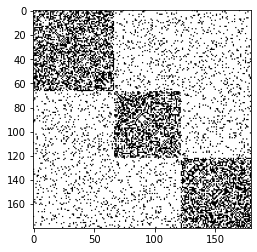

In [33]:
plt.imshow(XI,cmap='binary')

In [34]:
plt.imshow(XO,cmap='binary')

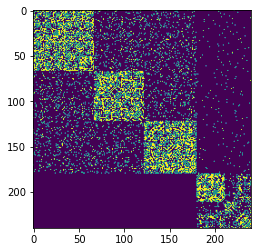

In [35]:
G = np.block([
    [XI, affiliation],
    [np.zeros((nO,nI)), XO]
])
plt.imshow(G)

## Inference

As defined in the paper, the Algorithm 1 only uses as inputs the observed adjacency matrices and the affiliation matrix. The initial clustering is determined by spectral clustering but can also be find with hierarchical clustering for example. Here we will use the spectral clustering.

### ASC on the organization level

In [36]:
DO = np.diag(XO@np.ones(nO))
LO = DO - XO
sqrt_dO = np.sqrt(XO.sum(axis = 1))
LsymO = LO / sqrt_dO[:,None]/sqrt_dO[:,None]
LabsO = np.eye(LsymO.shape[0]) - LsymO
eigen_valO, eigen_vecO = np.linalg.eigh(LabsO)

In [37]:
plt.scatter(range(len(eigen_valO)),np.sort(np.abs(eigen_valO))[::-1])
plt.show() #k = 2

We observe that spectral clustering doesn't allow us to retrieve the exact number of clusters from the inter-organizations level. With the full procedure, this would not have been an issue as we would have checked also the neighbouring values of this estimated value of QO but as we only compute a single step, we know that the estimated parameters are going to look be far from the true ones.

In [65]:
init_QO = 2

In [66]:
index = np.argsort(np.abs(eigen_valO))[::-1]
yi = eigen_vecO[:, index[0:init_QO]]
kmeansO = KMeans(n_clusters=init_QO, random_state=0).fit(yi)

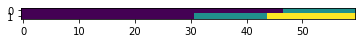

In [67]:
labelsO = np.sort(kmeansO.labels_)
ordered_nodes = np.where(ZO == 1)[1]
diff = np.concatenate([[labelsO], [ordered_nodes]])
plt.imshow(diff)
plt.show()

### ASC on the individual level

In [40]:
DI = np.diag(XI@np.ones(nI))
LI = DI - XI
sqrt_dI = np.sqrt(XI.sum(axis = 1))
LsymI = LI / sqrt_dI[:,None]/sqrt_dI[:,None]
LabsI = np.eye(LsymI.shape[0]) - LsymI
eigen_valI, eigen_vecI = np.linalg.eigh(LabsI)

In [41]:
plt.scatter(range(len(eigen_valI)),np.sort(np.abs(eigen_valI))[::-1])
plt.show() #k = 3

In [68]:
init_QI = 3

In [69]:
index = np.argsort(np.abs(eigen_valI))[::-1]
yi = eigen_vecI[:, index[0:init_QI]]
kmeansI = KMeans(n_clusters=init_QI, random_state=0).fit(yi)

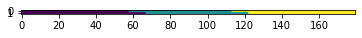

In [70]:
labelsI = np.sort(kmeansI.labels_)
ordered_nodes = np.where(ZI == 1)[1]
diff = np.concatenate([[labelsI], [ordered_nodes]])
plt.imshow(diff)
plt.show()

## VEM

In [71]:
epsilon = 10**-6

In [75]:
toI = np.zeros((nI, init_QI))

for i in range(nI):
    for j in range(init_QI):
        if j==labelsI[i]:
            toI[i,j]=1-(init_QI-1)*epsilon
        else:
            toI[i,j]=epsilon

In [76]:
toO = np.zeros((nO, init_QO))

for i in range(nO):
    for j in range(init_QO):
        if j==labelsO[i]:
            toO[i,j]=1-(init_QO-1)*epsilon
        else:
            toO[i,j]=epsilon

In [102]:
bound, new_pi, theta, to = algo_VEM(init_QI,init_QO,nI,nO,toI,toO,affiliation,XO,XI)

0 -9205.141202625664
1 -8546.63452019647
2 -8533.814820874768
3 -8488.20206934139


## Results

In [103]:
print("----------")
print(pi)
print(new_pi)
print("----------")
print(gamma)
print(theta[0])
print("----------")
print(alphaO)
print(theta[1])
print("----------")
print(alphaI)
print(theta[2])
print("----------")

----------
[0.5 0.2 0.3]
[0.33333367 0.66666633]
----------
[[0.8 0.1 0.1]
 [0.1 0.8 0.1]
 [0.1 0.1 0.8]]
[[0.3928569  0.36290315]
 [0.28571449 0.31451609]
 [0.32142861 0.32258076]]
----------
[[0.6 0.1 0.3]
 [0.1 0.5 0.2]
 [0.1 0.2 0.5]]
[[0.67368265 0.30375016]
 [0.30375016 0.29358975]]
----------
[[0.5 0.1 0.1]
 [0.1 0.5 0.1]
 [0.1 0.1 0.5]]
[[0.48846543 0.10420701 0.09855973]
 [0.10420701 0.49292751 0.09686606]
 [0.09855973 0.09686606 0.51723946]]
----------


In [116]:
labelsO = np.sort(kmeansO.labels_)
ordered_nodes = np.where(ZO == 1)[1]
new_labelsO = np.where(np.round(to[0]) == 1)[1]
new_labelsO = np.sort(new_labelsO)
diff = np.concatenate([[new_labelsO], [labelsO], [ordered_nodes]])
plt.imshow(diff)
plt.show()

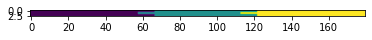

In [117]:
labelsI = np.sort(kmeansI.labels_)
new_labelsI = np.where(np.round(to[1]) == 1)[1]
new_labelsI = np.sort(new_labelsI)
ordered_nodes = np.where(ZI == 1)[1]
diff = np.concatenate([[new_labelsI], [labelsI], [ordered_nodes]])
plt.imshow(diff)
plt.show()

In [118]:
new_labelsI = np.where(np.round(to[1]) == 1)[1]
new_labelsI = np.sort(new_labelsI)
ordered_nodes = np.where(ZI == 1)[1]
diff = np.concatenate([[new_labelsI], [ordered_nodes]])
plt.imshow(diff)
plt.show()

We can observe that as expected, the clustering obtained for the inter-organization level is totally different from the true one. However, in the case of the inter-individual level, the clustering obtained by using the MLVSBM seems to be closed to the true one.

## Test with a new network

In [133]:
nO = 60
nI = 180

QO = QI = 3 #Number of bocks on the lower and upper level

pi = np.array([0.4, 0.3, 0.3]) #Block proportion for the upper level (sum=1)

gamma = np.array([[0.8,0.1,0.1],
                [0.1,0.8,0.1],
                [0.1,0.1,0.8]]) #Block proportion for the lower level (sum on columns=1)

alphaO = np.array([[0.6,0.1,0.1],
                 [0.1,0.6,0.1],
                 [0.1,0.1,0.5]]) #Connection matrix between organizations

alphaI = np.array([[0.5,0.1,0.1],
                 [0.1,0.5,0.1],
                 [0.1,0.1,0.5]]) #Connection matrix between individuals

In [134]:
rand = np.random.multinomial(1,pi,nO) #Organisation belongs to which block
# we want to sort Z by class
class0 = list()
class1 = list()
class2 = list()

for i in range(nO):
    if classe(i,rand) == 0:
        class0.append([1,0,0])
    elif classe(i,rand) == 1:
        class1.append([0,1,0])
    else:
        class2.append([0,0,1])
ZO = np.concatenate([class0, class1, class2])

affiliation = np.zeros((nI,nO)) #Affiliation matrix between individuals and organisation
for i in range(nI):
    j = sample(range(nO), 1)
    affiliation[i, j] = 1
    
randI = list()
for i in range(nI):
    j = np.where(affiliation[i,:]==1) #the index of the organisation to which the individual i belongs
    randI.append(np.random.multinomial(1,gamma[:,classe(j[0][0],ZO)].reshape((QO,)),1)[0])#ZO[j] is the the block to which the organisation j belongs

class0 = list()
class1 = list()
class2 = list()

for i in range(nI):
    if classe(i,randI) == 0:
        class0.append([1,0,0])
    elif classe(i,randI) == 1:
        class1.append([0,1,0])
    else:
        class2.append([0,0,1])
ZI = np.concatenate([class0, class1, class2])

XI = np.zeros((nI,nI)) #Adjacency matrix for the individuals
XO = np.zeros((nO,nO)) #Adjacency matrix for the organisations

for i in range(nI):
    for j in range(i+1,nI):
        XI[i,j] = XI[j,i] = np.random.binomial(1, alphaI[classe(i,ZI),classe(j,ZI)], size=1)[0]
        
for i in range(nO):
    for j in range(i+1,nO):
        XO[i,j] = XO[j,i] = np.random.binomial(1, alphaO[classe(i,ZO),classe(j,ZO)], size=1)[0]

In [135]:
DO = np.diag(XO@np.ones(nO))
LO = DO - XO
sqrt_dO = np.sqrt(XO.sum(axis = 1))
LsymO = LO / sqrt_dO[:,None]/sqrt_dO[:,None]
LabsO = np.eye(LsymO.shape[0]) - LsymO
eigen_valO, eigen_vecO = np.linalg.eigh(LabsO)

plt.scatter(range(len(eigen_valO)),np.sort(np.abs(eigen_valO))[::-1])
plt.show() #k = 2

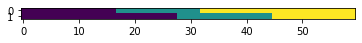

In [136]:
init_QO = 3

index = np.argsort(np.abs(eigen_valO))[::-1]
yi = eigen_vecO[:, index[0:init_QO]]
kmeansO = KMeans(n_clusters=init_QO, random_state=0).fit(yi)

labelsO = np.sort(kmeansO.labels_)
ordered_nodes = np.where(ZO == 1)[1]
diff = np.concatenate([[labelsO], [ordered_nodes]])
plt.imshow(diff)
plt.show()

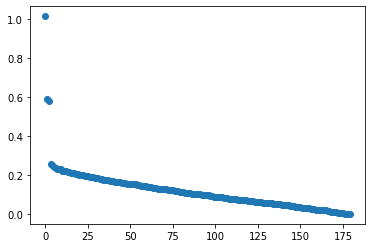

In [137]:
DI = np.diag(XI@np.ones(nI))
LI = DI - XI
sqrt_dI = np.sqrt(XI.sum(axis = 1))
LsymI = LI / sqrt_dI[:,None]/sqrt_dI[:,None]
LabsI = np.eye(LsymI.shape[0]) - LsymI
eigen_valI, eigen_vecI = np.linalg.eigh(LabsI)

plt.scatter(range(len(eigen_valI)),np.sort(np.abs(eigen_valI))[::-1])
plt.show() #k = 3

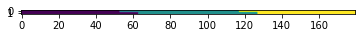

In [138]:
init_QI = 3

index = np.argsort(np.abs(eigen_valI))[::-1]
yi = eigen_vecI[:, index[0:init_QI]]
kmeansI = KMeans(n_clusters=init_QI, random_state=0).fit(yi)

labelsI = np.sort(kmeansI.labels_)
ordered_nodes = np.where(ZI == 1)[1]
diff = np.concatenate([[labelsI], [ordered_nodes]])
plt.imshow(diff)
plt.show()

In [139]:
epsilon = 10**-6

toI = np.zeros((nI, init_QI))

for i in range(nI):
    for j in range(init_QI):
        if j==labelsI[i]:
            toI[i,j]=1-(init_QI-1)*epsilon
        else:
            toI[i,j]=epsilon
            
toO = np.zeros((nO, init_QO))

for i in range(nO):
    for j in range(init_QO):
        if j==labelsO[i]:
            toO[i,j]=1-(init_QO-1)*epsilon
        else:
            toO[i,j]=epsilon

In [140]:
bound, new_pi, theta, to = algo_VEM(init_QI,init_QO,nI,nO,toI,toO,affiliation,XO,XI)

0 -9140.777863252515
1 -8373.21405076342


In [141]:
print("----------")
print(pi)
print(new_pi)
print("----------")
print(gamma)
print(theta[0])
print("----------")
print(alphaO)
print(theta[1])
print("----------")
print(alphaI)
print(theta[2])
print("----------")

----------
[0.4 0.3 0.3]
[0.34999995 0.13333393 0.51666612]
----------
[[0.8 0.1 0.1]
 [0.1 0.8 0.1]
 [0.1 0.1 0.8]]
[[0.34482757 0.250001   0.37755084]
 [0.43103396 0.20833481 0.34693875]
 [0.22413848 0.54166419 0.27551041]]
----------
[[0.6 0.1 0.1]
 [0.1 0.6 0.1]
 [0.1 0.1 0.5]]
[[0.61428403 0.51190282 0.09677506]
 [0.51190282 0.32142826 0.157259  ]
 [0.09677506 0.157259   0.37634358]]
----------
[[0.5 0.1 0.1]
 [0.1 0.5 0.1]
 [0.1 0.1 0.5]]
[[0.49820639 0.10664759 0.0985333 ]
 [0.10664759 0.50644692 0.09669894]
 [0.0985333  0.09669894 0.49564392]]
----------


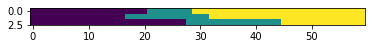

In [142]:
labelsO = np.sort(kmeansO.labels_)
ordered_nodes = np.where(ZO == 1)[1]
new_labelsO = np.where(np.round(to[0]) == 1)[1]
new_labelsO = np.sort(new_labelsO)
diff = np.concatenate([[new_labelsO], [labelsO], [ordered_nodes]])
plt.imshow(diff)
plt.show()

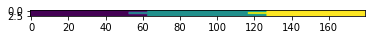

In [143]:
labelsI = np.sort(kmeansI.labels_)
new_labelsI = np.where(np.round(to[1]) == 1)[1]
new_labelsI = np.sort(new_labelsI)
ordered_nodes = np.where(ZI == 1)[1]
diff = np.concatenate([[new_labelsI], [labelsI], [ordered_nodes]])
plt.imshow(diff)
plt.show()